In [19]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

In [20]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('../HSG Historical Data.csv')

In [21]:
# convert date field from string to Date format and make it index
def tranformData(df: pd.DataFrame):
  df['Date'] = pd.to_datetime(df.Date, format='%m/%d/%Y')
  df['Price'] = df['Price'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['Open'] = df['Open'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['High'] = df['High'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['Low'] = df['Low'].astype(str).apply(lambda x: float(x.replace(',', '')))
  def convert_to_number(x):
      if 'M' in x:
          return float(x.replace('M', '')) * 1000000
      elif 'K' in x:
          return float(x.replace('K', '')) * 1000
      else:
          return float(x)
  df['Vol.'] = df['Vol.'].apply(convert_to_number)
  df['Change %'] = df['Change %'].apply(lambda x: float(x.strip('%'))/100)

In [22]:
tranformData(df)
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2023-06-02,15500.0,15250.0,15700.0,15250.0,15490000.0,0.0197
1,2023-06-01,15200.0,15300.0,15350.0,14950.0,15030000.0,-0.0130
2,2023-05-31,15400.0,15800.0,15850.0,15200.0,36230000.0,-0.0284
3,2023-05-30,15850.0,15800.0,16000.0,15600.0,13350000.0,0.0096
4,2023-05-29,15700.0,15500.0,15700.0,15350.0,9600000.0,0.0228
...,...,...,...,...,...,...,...
1366,2017-12-07,14666.1,15098.3,15184.8,14550.9,5520000.0,-0.0155
1367,2017-12-06,14896.6,14464.4,15069.5,14320.4,9470000.0,0.0258
1368,2017-12-05,14522.1,15040.7,15242.4,14522.1,12280000.0,-0.0175
1369,2017-12-04,14781.4,14061.0,14781.4,13830.5,13710000.0,0.0688


In [23]:
df=df.sort_values(['Date'], ascending=[True])
df = df.reset_index(drop=True)
df1=df.reset_index()['Price']

In [24]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [25]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [26]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [27]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [28]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [29]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [30]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
14/14 [==============================] - 3s 53ms/step - loss: 0.0384 - val_loss: 0.0047
Epoch 2/100
14/14 [==============================] - 0s 29ms/step - loss: 0.0082 - val_loss: 0.0016
Epoch 3/100
14/14 [==============================] - 0s 29ms/step - loss: 8.5670e-04 - val_loss: 0.0036
Epoch 4/100
14/14 [==============================] - 0s 28ms/step - loss: 6.2856e-04 - val_loss: 7.9053e-04
Epoch 5/100
14/14 [==============================] - 0s 29ms/step - loss: 3.1716e-04 - val_loss: 0.0010
Epoch 6/100
14/14 [==============================] - 0s 29ms/step - loss: 2.7641e-04 - val_loss: 0.0012
Epoch 7/100
14/14 [==============================] - 0s 29ms/step - loss: 2.7330e-04 - val_loss: 0.0010
Epoch 8/100
14/14 [==============================] - 0s 29ms/step - loss: 2.6611e-04 - val_loss: 9.3359e-04
Epoch 9/100
14/14 [==============================] - 0s 29ms/step - loss: 2.6069e-04 - val_loss: 0.0011
Epoch 10/100
14/14 [==============================] - 0s 33ms/st

In [31]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

2/2 [==============================] - 0s 6ms/step


In [32]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [33]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 15795.099110894895
Testing RMSE: 20276.4614995919


In [34]:
x_input = val_data[60:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = 77
i = 0
while i < 30:
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[1:])
        print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i += 1


0 day input [0.29057814 0.30234011 0.30887454 0.32847782 0.31932962 0.33762602
 0.32717093 0.30626077 0.32717093 0.31148831 0.29057814 0.2944988
 0.32063651 0.31932962 0.31410208 0.31540896 0.33501225 0.3389329
 0.3389329  0.34285356 0.33762602 0.32063651 0.34677421 0.33501225
 0.33762602 0.32455716 0.33501225 0.32847782 0.33239847 0.3297847
 0.34154667 0.3389329  0.34677421 0.3389329  0.33501225 0.33762602
 0.34416044 0.35069487 0.34285356 0.33762602 0.32194339 0.32717093
 0.32063651 0.30887454 0.31540896 0.32194339 0.32455716 0.31410208
 0.31410208 0.30495388 0.29580568 0.30495388 0.32455716 0.31410208
 0.31932962 0.31932962 0.32063651 0.32194339 0.33109159 0.33109159
 0.33501225 0.34023979 0.3297847  0.32717093 0.31932962 0.31802273
 0.32063651 0.33631913 0.33109159 0.32194339 0.31932962 0.31540896
 0.32455716 0.32847782 0.31671585 0.31148831 0.31932962]


0 day output [[0.32152104]]
1 day input [0.30234011 0.30887454 0.32847782 0.31932962 0.33762602 0.32717093
 0.30626077 0.32717093 0.31148831 0.29057814 0.2944988  0.32063651
 0.31932962 0.31410208 0.31540896 0.33501225 0.3389329  0.3389329
 0.34285356 0.33762602 0.32063651 0.34677421 0.33501225 0.33762602
 0.32455716 0.33501225 0.32847782 0.33239847 0.3297847  0.34154667
 0.3389329  0.34677421 0.3389329  0.33501225 0.33762602 0.34416044
 0.35069487 0.34285356 0.33762602 0.32194339 0.32717093 0.32063651
 0.30887454 0.31540896 0.32194339 0.32455716 0.31410208 0.31410208
 0.30495388 0.29580568 0.30495388 0.32455716 0.31410208 0.31932962
 0.31932962 0.32063651 0.32194339 0.33109159 0.33109159 0.33501225
 0.34023979 0.3297847  0.32717093 0.31932962 0.31802273 0.32063651
 0.33631913 0.33109159 0.32194339 0.31932962 0.31540896 0.32455716
 0.32847782 0.31671585 0.31148831 0.31932962 0.32152104]
1 day output [[0.32394558]]
2 day input [0.30887454 0.32847782 0.31932962 0.33762602 0.32717093 0.30

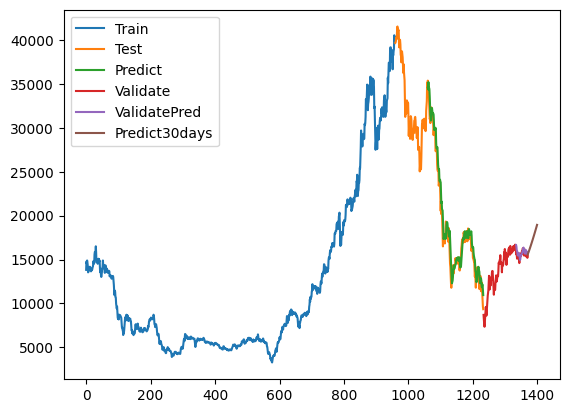

In [35]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()